In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

import wandb
wandb.login()

random.seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [28]:
# Language Model
SOS_token = 0
EOS_token = 1

class Language:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "<", EOS_token: ">"}
        self.n_chars = 2  # Count SOS and EOS

    def addWord(self, word):
        for char in word:
            self.addChar(char)

    def addChar(self, char):
        if char not in self.word2index:
            self.word2index[char] = self.n_chars
            self.word2count[char] = 1
            self.index2word[self.n_chars] = char
            self.n_chars += 1
        else:
            self.word2count[char] += 1

In [29]:
def get_data(lang: str, type: str) -> list[list[str]]:
    """
    Returns: 'pairs': list of [input_word, target_word] pairs
    """
    path = "../aksharantar_sampled/{}/{}_{}.csv".format(lang, lang, type)
    df = pd.read_csv(path, header=None)
    pairs = df.values.tolist()
    return pairs

In [30]:
def get_languages(lang: str):
    """
    Returns 
    1. input_lang: input language - English
    2. output_lang: output language - Given language
    3. pairs: list of [input_word, target_word] pairs
    """
    input_lang = Language('eng')
    output_lang = Language(lang)
    pairs = get_data(lang, "train")
    for pair in pairs:
        input_lang.addWord(pair[0])
        output_lang.addWord(pair[1])
    return input_lang, output_lang, pairs

In [31]:
def get_cell(cell_type: str):
    if cell_type == "LSTM":
        return nn.LSTM
    elif cell_type == "GRU":
        return nn.GRU
    elif cell_type == "RNN":
        return nn.RNN
    else:
        raise Exception("Invalid cell type")
    
def get_optimizer(optimizer: str):
    if optimizer == "SGD":
        return optim.SGD
    elif optimizer == "ADAM":
        return optim.Adam
    else:
        raise Exception("Invalid optimizer")

In [32]:
class Encoder(nn.Module):
    def __init__(self,
                 in_sz: int,
                 embed_sz: int,
                 hidden_sz: int,
                 cell_type: str,
                 n_layers: int,
                 dropout: float):
        
        super(Encoder, self).__init__()
        self.hidden_sz = hidden_sz
        self.n_layers = n_layers
        self.dropout = dropout
        self.cell_type = cell_type
        self.embedding = nn.Embedding(in_sz, embed_sz)

        self.rnn = get_cell(cell_type)(input_size = embed_sz,
                                       hidden_size = hidden_sz,
                                       num_layers = n_layers,
                                       dropout = dropout)
        
    def forward(self, input, hidden, cell):
        embedded = self.embedding(input).view(1, 1, -1)

        if(self.cell_type == "LSTM"):
            output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        else:
            output, hidden = self.rnn(embedded, hidden)
            
        return output, hidden, cell
    
    def initHidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_sz, device=device)

In [33]:
class AttentionDecoder(nn.Module):
    def __init__(self,
                 out_sz: int,
                 embed_sz: int,
                 hidden_sz: int,
                 cell_type: str,
                 n_layers: int,
                 dropout: float):

        super(AttentionDecoder, self).__init__()
        self.hidden_sz = hidden_sz
        self.n_layers = n_layers
        self.dropout = dropout
        self.cell_type = cell_type
        self.embedding = nn.Embedding(out_sz, embed_sz)

        self.attn = nn.Linear(hidden_sz + embed_sz, 50)
        self.attn_combine = nn.Linear(hidden_sz + embed_sz, hidden_sz)

        self.rnn = get_cell(cell_type)(input_size = hidden_sz,
                                       hidden_size = hidden_sz,
                                       num_layers = n_layers,
                                       dropout = dropout)
        
        self.out = nn.Linear(hidden_sz, out_sz)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell, encoder_outputs):
        embedding = self.embedding(input).view(1, 1, -1)

        attn_weights = F.softmax(self.attn(torch.cat((embedding[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedding[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        if(self.cell_type == "LSTM"):
            output, (hidden, cell) = self.rnn(output, (hidden, cell))
        else:
            output, hidden = self.rnn(output, hidden)

        output = self.softmax(self.out(output[0]))
        return output, hidden, cell, attn_weights
    
    def initHidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_sz, device=device)

In [34]:
def indexesFromWord(lang:Language, word:str):
    return [lang.word2index[char] for char in word]

def tensorFromWord(lang:Language, word:str):
    indexes = indexesFromWord(lang, word)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(input_lang:Language, output_lang:Language, pair:list[str]):
    input_tensor = tensorFromWord(input_lang, pair[0])
    target_tensor = tensorFromWord(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [35]:
def params_definition(): 
    """
    params:

        embed_size : size of embedding (input and output) (8, 16, 32, 64)
        hidden_size : size of hidden layer (64, 128, 256, 512)
        cell_type : type of cell (LSTM, GRU, RNN)
        num_layers : number of layers in encoder (1, 2, 3)
        dropout : dropout probability
        learning_rate : learning rate
        teacher_forcing_ratio : teacher forcing ratio (0.5 fixed for now)
        optimizer : optimizer (SGD, Adam)
        max_length : maximum length of input word (50 fixed for now)

    """
    pass

In [36]:
PRINT_EVERY = 5000
PLOT_EVERY = 100

In [37]:
class Translator:
    def __init__(self, lang: str, params: dict):
        self.lang = lang
        self.input_lang, self.output_lang, self.pairs = get_languages(self.lang)
        self.input_size = self.input_lang.n_chars
        self.output_size = self.output_lang.n_chars

        self.training_pairs = [tensorsFromPair(self.input_lang, self.output_lang, pair) for pair in self.pairs]

        self.encoder = Encoder(in_sz = self.input_size,
                             embed_sz = params["embed_size"],
                             hidden_sz = params["hidden_size"],
                             cell_type = params["cell_type"],
                             n_layers = params["num_layers"],
                             dropout = params["dropout"]).to(device)
        
        self.decoder = AttentionDecoder(out_sz = self.output_size,
                             embed_sz = params["embed_size"],
                             hidden_sz = params["hidden_size"],
                             cell_type = params["cell_type"],
                             n_layers = params["num_layers"],
                             dropout = params["dropout"]).to(device)

        self.encoder_optimizer = get_optimizer(params["optimizer"])(self.encoder.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
        self.decoder_optimizer = get_optimizer(params["optimizer"])(self.decoder.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
        
        self.criterion = nn.NLLLoss()

        self.teacher_forcing_ratio = params["teacher_forcing_ratio"]
        self.max_length = params["max_length"]

    def train_single(self, input_tensor, target_tensor):
        encoder_hidden = self.encoder.initHidden()
        encoder_cell = self.encoder.initHidden()

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        encoder_outputs = torch.zeros(self.max_length, self.encoder.hidden_sz, device=device)

        loss = 0

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = self.encoder(input_tensor[ei], encoder_hidden, encoder_cell)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden, decoder_cell = encoder_hidden, encoder_cell

        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False

        if use_teacher_forcing:
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_cell, decoder_attention = self.decoder(decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
                loss += self.criterion(decoder_output, target_tensor[di])

                decoder_input = target_tensor[di]
        else:
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_cell, decoder_attention = self.decoder(decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
                loss += self.criterion(decoder_output, target_tensor[di])

                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()
                if decoder_input.item() == EOS_token:
                    break

        loss.backward()
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return loss.item() / target_length
    
    def train(self, iters=-1):
        start_time = time.time()
        plot_losses = []
        print_loss_total = 0
        plot_loss_total = 0

        random.shuffle(self.training_pairs)
        iters = len(self.training_pairs) if iters == -1 else iters

        for iter in range(1, iters):
            training_pair = self.training_pairs[iter - 1]
            input_tensor = training_pair[0]
            target_tensor = training_pair[1]

            loss = self.train_single(input_tensor, target_tensor)
            print_loss_total += loss
            plot_loss_total += loss

            if iter % PRINT_EVERY == 0:
                print_loss_avg = print_loss_total / PRINT_EVERY
                print_loss_total = 0
                current_time = time.time()
                print("Loss: {:.4f} | Iterations: {} | Time: {:.3f}".format(print_loss_avg, iter, current_time - start_time))

            if iter % PLOT_EVERY == 0:
                plot_loss_avg = plot_loss_total / PLOT_EVERY
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
            
        return plot_losses
    
    def evaluate(self, word):
        with torch.no_grad():
            input_tensor = tensorFromWord(self.input_lang, word)
            input_length = input_tensor.size()[0]
            encoder_hidden = self.encoder.initHidden()
            encoder_cell = self.encoder.initHidden()

            encoder_outputs = torch.zeros(self.max_length, self.encoder.hidden_sz, device=device)

            for ei in range(input_length):
                encoder_output, encoder_hidden, encoder_cell = self.encoder(input_tensor[ei], encoder_hidden, encoder_cell)
                encoder_outputs[ei] += encoder_output[0, 0]

            decoder_input = torch.tensor([[SOS_token]], device=device)
            decoder_hidden, decoder_cell = encoder_hidden, encoder_cell

            decoded_chars = ""
            decoder_attentions = torch.zeros(self.max_length, self.max_length)

            for di in range(self.max_length):
                decoder_output, decoder_hidden, decoder_cell, decoder_attention = self.decoder(decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
                decoder_attentions[di] = decoder_attention.data
                topv, topi = decoder_output.topk(1)
                
                if topi.item() == EOS_token:
                    break
                else:
                    decoded_chars += self.output_lang.index2word[topi.item()]

                decoder_input = topi.squeeze().detach()

            return decoded_chars, decoder_attentions[:di + 1]
        
    def test_validate(self, type:str):
        pairs = get_data(self.lang, type)
        accuracy = 0
        for pair in pairs:
            output, _ = self.evaluate(pair[0])
            if output == pair[1]:
                accuracy += 1
        return accuracy / len(pairs)

In [38]:
def plot_losses(plot_losses, title: str):
    # return plot of losses
    x_labels = [i * PLOT_EVERY for i in range(1, len(plot_losses) + 1)]
    plt.plot(x_labels, plot_losses, color="blue")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title(title)
    plt.show()

In [39]:
sweep_configuration = {
    "method": "bayes",
    "metric": {
        "name": "validation_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "embed_size": {
            "values": [8, 16, 32]
        },
        "hidden_size": {
            "values": [64, 128, 256, 512]
        },
        "cell_type": {
            "values": ["RNN", "LSTM", "GRU"]
        },
        "num_layers": {
            "values": [1, 2, 3]
        },
        "dropout": {
            "values": [0, 0.1, 0.2]
        },
        "learning_rate": {
            "values": [0.0005, 0.001, 0.005]
        },
        "optimizer": {
            "values": ["SGD", "ADAM"]
        },
        "teacher_forcing_ratio": {
            'value': 0.5
        },
        "max_length": {
            'value': 50
        },
        "weight_decay": {
            "values": [0, 1e-1, 1e-3, 1e-5]
        }
    }
}

In [40]:
count = 0

def train_sweep():
    global count
    count += 1

    run = wandb.init()
    config = wandb.config
    run.name = "embed_size: {} | hidden_size: {} | cell_type: {} | num_layers: {} | dropout: {} | learning_rate: {} | optimizer: {} | teacher_forcing_ratio: {} | max_length: {} | weight_decay: {}".format(config.embed_size, config.hidden_size, config.cell_type, config.num_layers, config.dropout, config.learning_rate, config.optimizer, config.teacher_forcing_ratio, config.max_length, config.weight_decay)

    model = Translator('tam', config)

    epochs = 10
    old_validation_accuracy = 0

    for epoch in range(epochs):
        print("Epoch: {}".format(epoch + 1))
        plot_losses = model.train()

        # take average of plot losses as training loss
        training_loss = sum(plot_losses) / len(plot_losses)
        
        training_accuracy = model.test_validate('train')
        print("Training Accuracy: {:.4f}".format(training_accuracy))

        validation_accuracy = model.test_validate('valid')
        print("Validation Accuracy: {:.4f}".format(validation_accuracy))

        wandb.log({
            "epoch": epoch + 1,
            "training_loss": training_loss,
            "training_accuracy": training_accuracy,
            "validation_accuracy": validation_accuracy
        })

        if epoch > 0:
            if validation_accuracy < 0.0001:
                break

            if validation_accuracy < 0.9 * old_validation_accuracy:
                break

        old_validation_accuracy = validation_accuracy

    test_accuracy = model.test_validate('test')
    print("Test Accuracy: {:.4f}".format(test_accuracy))

    wandb.log({
        "test_accuracy": test_accuracy
    })

    run.finish()

In [41]:
params = {
    "embed_size": 32,
    "hidden_size": 256,
    "cell_type": "RNN",
    "num_layers": 2,
    "dropout": .1,
    "learning_rate": 0.001,
    "optimizer": "SGD",
    "teacher_forcing_ratio": 0.5,
    "max_length": 50,
    "weight_decay": 0.001
}

model = Translator("tam", params)

model.encoder.load_state_dict(torch.load('../best_models_attn/encoder.pt'))
model.decoder.load_state_dict(torch.load('../best_models_attn/decoder.pt'))

<All keys matched successfully>

[['thernthedukkum', 'தேர்ந்தெடுக்கும்'], ['textiles', 'டெக்ஸ்டைல்ஸ்'], ['poayinar', 'போயினர்'], ['solanki', 'சோலாங்கி'], ['karavalaadugalai', 'கறவலாடுகளை'], ['vatamaerkil', 'வடமேற்கில்'], ['chalukiyargal', 'சாளுக்கியர்கள்'], ['solvadhaga', 'சொல்வதாக'], ['vidatheerkal', 'விடாதீர்கள்'], ['vanggikku', 'வங்கிக்கு']]
Input: thernthedukkum, Target: தேர்ந்தெடுக்கும், Output: தெர்ந்தெடுக்கும்


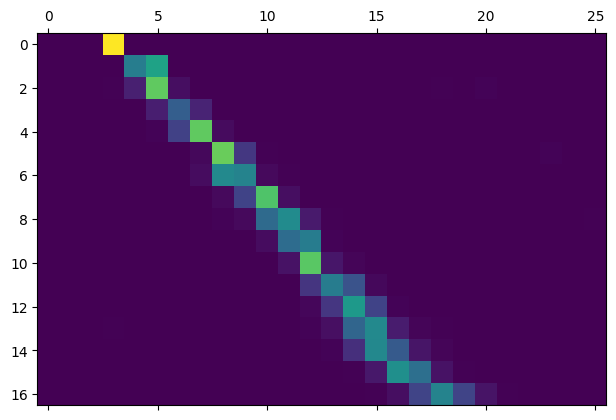


Input: textiles, Target: டெக்ஸ்டைல்ஸ், Output: டெக்டில்


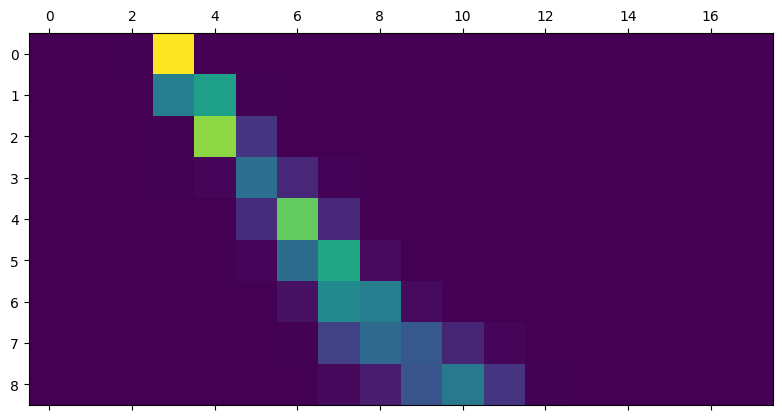


Input: poayinar, Target: போயினர், Output: போயினர்


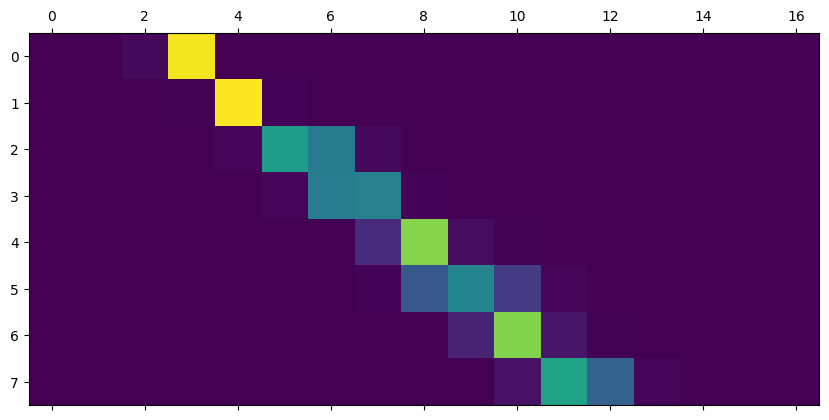


Input: solanki, Target: சோலாங்கி, Output: சோலாங்கி


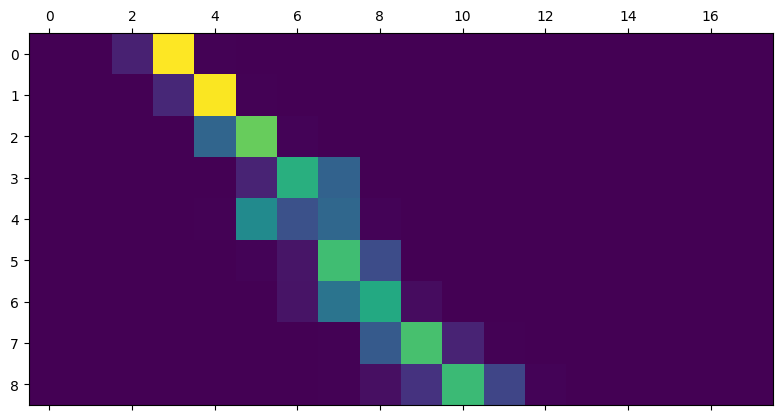


Input: karavalaadugalai, Target: கறவலாடுகளை, Output: கரவலாடுகளை


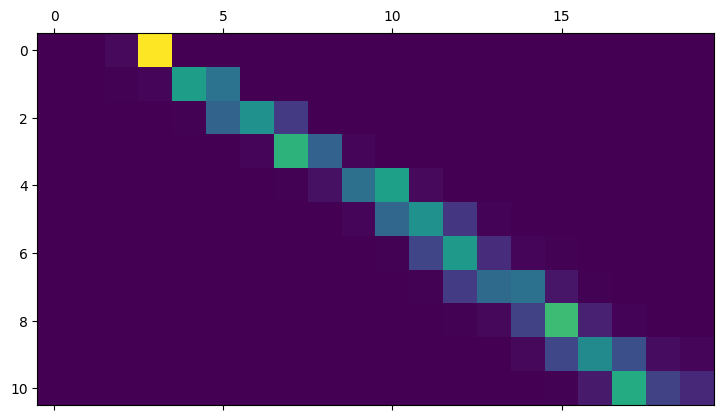


Input: vatamaerkil, Target: வடமேற்கில், Output: வடமேற்கில்


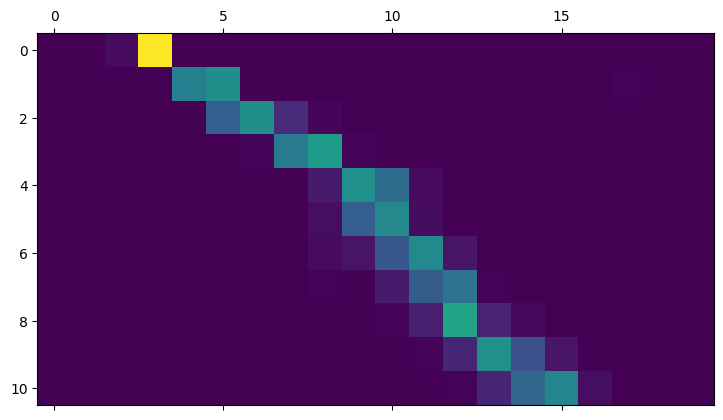


Input: chalukiyargal, Target: சாளுக்கியர்கள், Output: சலுகியர்கள்


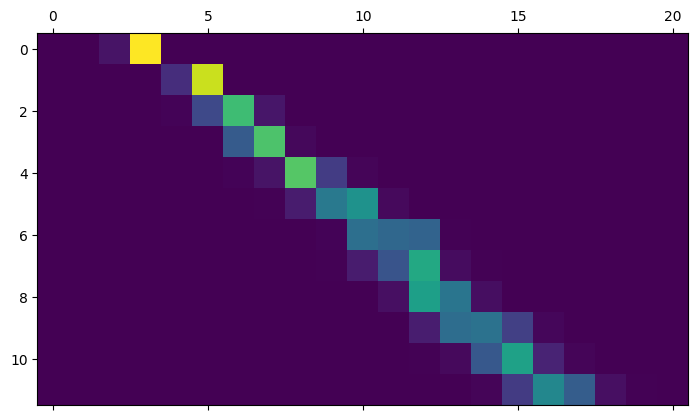


Input: solvadhaga, Target: சொல்வதாக, Output: சொல்வதக


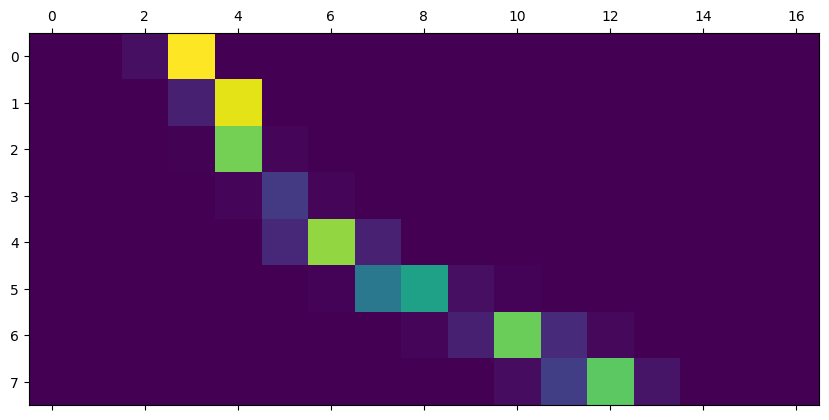


Input: vidatheerkal, Target: விடாதீர்கள், Output: விடதீர்கள்


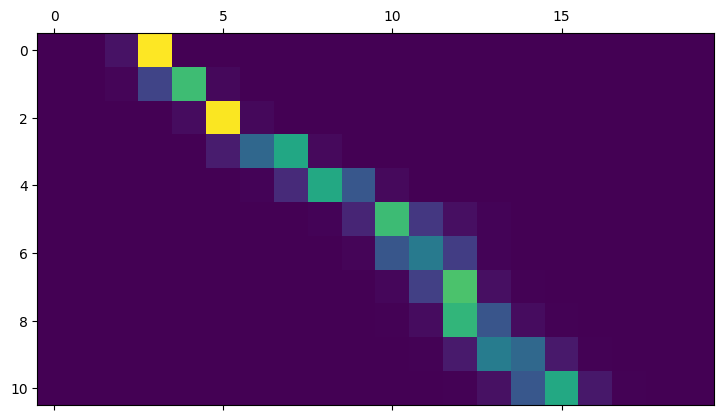

In [46]:
test_data = get_data("tam", "test") 
test_pairs_10  = random.sample(test_data, 10)
print(test_pairs_10)

for i in range(9):
    pair = test_pairs_10[i]
    output, attentions = model.evaluate(pair[0])
    print("Input: {}, Target: {}, Output: {}".format(pair[0], pair[1], output))
    
    attentions = attentions[:, :(10 + len(output))]
    plt.matshow(attentions.numpy())
    plt.show()

    print()